In [154]:
%pip install -e git+https://github.com/UN-GCPDS/python-gcpds.MI_prediction.git#egg=MI_prediction

Obtaining MI_prediction from git+https://github.com/UN-GCPDS/python-gcpds.MI_prediction.git#egg=MI_prediction
  Updating ./src/mi-prediction clone
  Running command git fetch -q --tags
  Running command git reset --hard -q b81dc91d270b847c96d3c2aa0a8d6bafe01ec10d
  Preparing metadata (setup.py) ... done
  Attempting uninstall: MI_prediction
    Found existing installation: MI-prediction 0.1
    Uninstalling MI-prediction-0.1:
      Successfully uninstalled MI-prediction-0.1
  Running setup.py develop for MI_prediction
Note: you may need to restart the kernel to use updated packages.


In [22]:
from MI_prediction.Utils.Datasets import  DataLoader_Rest, get_epochs, get_runs, get_labels
from MI_prediction.Datasets import Cho2017_Rest, BNCI2014001_Rest
from MI_prediction.Utils.Preprocess import filterbank_preprocessor, filterbank, FBCSP, moments, scaler_list
from MI_prediction.Utils.Windowers import create_windows
from MI_prediction.Utils.Datautils import features_by_channels
from MI_prediction.Models import DLSMR
from braindecode.preprocessing.preprocess import exponential_moving_standardize, preprocess, Preprocessor, scale
from scikeras.wrappers import KerasRegressor 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import welch

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_val_score,GridSearchCV,LeaveOneOut,cross_val_predict

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from mne.preprocessing import compute_current_source_density
import tensorflow as tf

from MI_prediction.Utils.Wrappers import MultiInputRegressor, MultiInputScaler

import time
import pickle

# GIGAScience Cho2017

In [2]:
dl = DataLoader_Rest(dataset_name=Cho2017_Rest())

subjects = np.arange(1,53)
subjects = subjects[(subjects!=32) & (subjects!=46) & (subjects!=49)]

duration=66

## Preprocessing

### For moments

In [4]:
fb = filterbank_preprocessor([(8.,15.),(15.,25.)], method='iir',iir_params={'order':5,'ftype':'butter'})

preprocessors_mts = [
        Preprocessor('pick_types', eeg=True, meg=False, stim=False),  # Keep EEG sensors
        Preprocessor('pick_channels', ch_names=['C3', 'C4', 'Cz', 'P3', 'P4', 'Pz']),  # Keep only EEG channels
        Preprocessor(scale, factor=1e3, apply_on_array=True),  # Convert from V to uV
        Preprocessor('filter',l_freq=1., h_freq=None, method='iir',iir_params={'order':5,'ftype':'butter'})
        ]

Ch_prep = [
        Preprocessor(compute_current_source_density,copy=False,apply_on_array=False)
        ]

st_offsets_mts, ed_offsets_mts = create_windows(win = 2, start_offset = 5, end_offset = -6, mi_duration = duration, overlap = 0.5)

band to filter: (8.0, 15.0) Hz
band to filter: (15.0, 25.0) Hz


### For PSD

In [5]:
preprocessors_psd = [
        Preprocessor('pick_types', eeg=True, meg=False, stim=False),  # Keep EEG sensors
        Preprocessor('pick_channels', ch_names=['C3', 'C4', 'Cz', 'P3', 'P4', 'Pz']), 
        Preprocessor(scale, factor=1e3, apply_on_array=True),  # Convert from V to uV
        Preprocessor('filter',l_freq=8., h_freq=30., method='iir',iir_params={'order':5,'ftype':'butter'}),
        Preprocessor(compute_current_source_density,copy=False,apply_on_array=False)
        ]
st_offsets_psd, ed_offsets_psd = create_windows(win = 55, start_offset = 5, end_offset = -6, mi_duration = duration, overlap = 0)

## Feature extraction

In [6]:
Epochs_mts = []
Epochs_psd = []

for s in subjects:
    print ("Subject: {}".format(s))
    tic = time.time()

    dl.load_data(subject_ids=[s])

    ds_f = filterbank(dl, preprocess=preprocessors_mts, filters=fb, channels_prep=Ch_prep)
    trials = [tr.get_trials(start_offset=st_offsets_mts, end_offset=ed_offsets_mts) for tr in ds_f]

    epochs_mts = []
    for nw in trials[0].keys():
        epochs_mts.append(np.concatenate([np.expand_dims(moments(get_epochs(epoch[nw].split('session')['session_0'])),axis=3) for epoch in trials],axis=-1))

    Epochs_mts.append(np.concatenate(epochs_mts, axis=2))

    fs = dl.dataset.datasets[0].raw.info['sfreq']

    dl.preprocess_data(preprocessors=preprocessors_psd)
    trials_psd = dl.get_trials(start_offset=st_offsets_psd, end_offset=ed_offsets_psd)

    Epochs_psd.append(welch(get_epochs(trials_psd['win_0'])[0],fs=fs,nperseg=int(2*fs))[-1])

    print("Elapsed: {}".format(time.time()-tic))

Epochs_mts = np.concatenate(Epochs_mts, axis=0)
Epochs_psd = np.concatenate(Epochs_psd, axis=0)

save_path = '/Volumes/GoogleDrive/Mi unidad/PhD_Thesis/Data/GIGA/2Class/'

Epochs_rest = {
    'Subjects': subjects,
    'Epochs_mts': Epochs_mts,
    'Epochs_psd': Epochs_psd
    }
pickle.dump(Epochs_rest, open(save_path+'Epochs_rest.pkl', 'wb'))

Subject: 1
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-b

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.168879270553589
Subject: 2
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 p

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.3987700939178467
Subject: 3
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching event

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.242453098297119
Subject: 4
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.256833791732788
Subject: 5
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epoch

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.143902063369751
Subject: 6
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)



IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from pr

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.248103141784668
Subject: 7
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- 

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- 

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.3635990619659424
Subject: 10
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment


/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 pr

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.1804909706115723
Subject: 11
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 1

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original tim

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.108842134475708
Subject: 12
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.2289106845855713
Subject: 13
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 1

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.073723316192627
Subject: 14
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching even

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.1335649490356445
Subject: 15
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 1

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.311601161956787
Subject: 16
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- 

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.3312389850616455
Subject: 18
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 1

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)



Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using dat

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.1904702186584473
Subject: 19
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 1

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching even

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.2608282566070557
Subject: 20
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 1

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original tim

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.162609100341797
Subject: 21
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.3053488731384277
Subject: 22
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 1

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.3897390365600586
Subject: 23
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 1

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.2626140117645264
Subject: 24
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 1

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching even

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.2121529579162598
Subject: 25
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 1

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.1781821250915527
Subject: 26
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 1

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.13273024559021
Subject: 27
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from pre

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.1247119903564453
Subject: 28
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 1

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching even

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.2856152057647705
Subject: 29
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 1

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.3311948776245117
Subject: 30
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 1

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching even

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.28364896774292
Subject: 31
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.2716379165649414
Subject: 33
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 1

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data f

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.264150619506836
Subject: 34
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


0 bad epochs dropped
Elapsed: 3.3157413005828857
Subject: 35
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz


/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)



IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data 

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.0991220474243164
Subject: 36
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 1

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.223177909851074
Subject: 37
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching even

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.085326910018921
Subject: 38
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data f

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- 

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 event

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.248296022415161
Subject: 40
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.1800620555877686
Subject: 41
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 1

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching event

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.227212905883789
Subject: 42
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters


/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.135699987411499
Subject: 43
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.2710659503936768
Subject: 44
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 1

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)



Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using dat

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.1414358615875244
Subject: 45
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 1

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching even

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.32149600982666
Subject: 47
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.2006068229675293
Subject: 48
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 1

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching even

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- 

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.2532591819763184
Subject: 51
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 1

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.2577033042907715
Subject: 52
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 1

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching even

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.1277997493743896


In [12]:
Epochs_rest.keys()

dict_keys(['Subjects', 'Epochs_mts', 'Epochs_psd'])

## Training

### Load and organize data

In [2]:
load_path = '/Volumes/GoogleDrive/Mi unidad/PhD_Thesis/Data/GIGA/2Class/'
load_label_path = '/Volumes/GoogleDrive/Mi unidad/PhD_Thesis/Results/GIGA/2Class/'

In [3]:
data = pickle.load(open(load_path+'Epochs_rest.pkl', 'rb'))

In [4]:
data.keys()

dict_keys(['Subjects', 'Epochs_mts', 'Epochs_psd'])

In [5]:
X = []
for i in range(data['Epochs_mts'].shape[-1]):
    X+=features_by_channels(data['Epochs_mts'][:,:,:,i])[0:2] # for C3 and C4
X+=features_by_channels(data['Epochs_psd'])[0:2]# for C3 and C4

labels = pickle.load(open(load_label_path+'acc_train.pkl', 'rb'))

In [86]:
sc = MultiInputScaler(scaler=StandardScaler(), input_feats=[x.shape[-1] for x in X], keep_dims=True)
X_train = sc.fit_transform(np.concatenate(X,axis=-1))

### multiple input scikit-learn

In [87]:
m = MultiInputRegressor(model=DLSMR,loss=tf.keras.losses.mae,
                    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                    epochs=200,batch_size=30,validation_split=0.1,
                    input_feats = [x.shape[-1] for x in X]
                    )

In [88]:
scy = StandardScaler()
yy = scy.fit_transform(np.asarray(labels['3.0']).reshape(-1, 1)).ravel()
#yy = np.asarray(labels['2.0'])

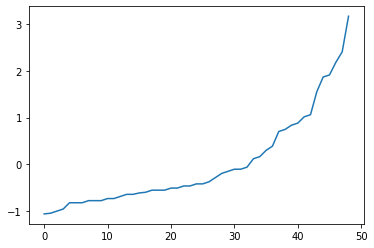

In [89]:
plt.plot(np.sort(yy))
plt.show()

In [90]:
reg = Pipeline([('scaler', sc), ('regressor', m)])

In [91]:
reg.fit(X=np.concatenate(X,axis=-1),y=yy)

Epoch 1/200


2022-08-13 01:15:32.316395: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - ETA: 0s - loss: 142.0952

2022-08-13 01:15:33.665323: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 2s 812ms/step - loss: 142.0952 - val_loss: 145.8410
Epoch 2/200
2/2 [==============================] - 0s 78ms/step - loss: 143.8044 - val_loss: 137.0256
Epoch 3/200
2/2 [==============================] - 0s 107ms/step - loss: 137.4729 - val_loss: 125.1401
Epoch 4/200
2/2 [==============================] - 0s 138ms/step - loss: 125.2683 - val_loss: 124.5317
Epoch 5/200
2/2 [==============================] - 0s 89ms/step - loss: 123.3290 - val_loss: 117.4650
Epoch 6/200
2/2 [==============================] - 0s 61ms/step - loss: 116.6262 - val_loss: 113.3808
Epoch 7/200
2/2 [==============================] - 0s 51ms/step - loss: 113.1104 - val_loss: 109.4406
Epoch 8/200
2/2 [==============================] - 0s 67ms/step - loss: 108.5712 - val_loss: 105.3342
Epoch 9/200
2/2 [==============================] - 0s 67ms/step - loss: 104.6287 - val_loss: 102.0760
Epoch 10/200
2/2 [==============================] - 0s 49ms/step - loss: 100.9265 - val_los

Pipeline(steps=[('scaler',
                 MultiInputScaler(input_feats=[270, 270, 270, 270, 513, 513],
                                  keep_dims=True, scaler=StandardScaler())),
                ('regressor',
                 MultiInputRegressor(batch_size=30, epochs=200, input_feats=[270, 270, 270, 270, 513, 513], loss=<function mean_absolute_error at 0x2aa2f9ee0>, model=<function DLSMR at 0x16e7d6ca0>, optimizer=<keras.optimizers.optimizer_v2.adam.Adam object at 0x3084ecb20>, validation_split=0.1))])

In [11]:

mdl = cross_val_predict(estimator=reg,X=np.concatenate(X,axis=-1),y=yy,cv=LeaveOneOut())

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Epoch 1/200


2022-08-13 00:48:33.913437: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-13 00:48:33.913677: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-08-13 00:48:34.092198: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-13 00:48:34.584161: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 513ms/step - loss: 140.4106 - val_loss: 149.8365
Epoch 2/200
2/2 [==============================] - 0s 66ms/step - loss: 147.4073 - val_loss: 140.7611
Epoch 3/200


2022-08-13 00:48:35.330308: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 46ms/step - loss: 141.5384 - val_loss: 133.6714
Epoch 4/200
2/2 [==============================] - 0s 43ms/step - loss: 131.6744 - val_loss: 124.5815
Epoch 5/200
2/2 [==============================] - 0s 47ms/step - loss: 124.1320 - val_loss: 122.1225
Epoch 6/200
2/2 [==============================] - 0s 55ms/step - loss: 119.8407 - val_loss: 115.4810
Epoch 7/200
2/2 [==============================] - 0s 47ms/step - loss: 114.0067 - val_loss: 112.6137
Epoch 8/200
2/2 [==============================] - 0s 74ms/step - loss: 111.2588 - val_loss: 108.5771
Epoch 9/200
2/2 [==============================] - 0s 46ms/step - loss: 106.8802 - val_loss: 104.3362
Epoch 10/200
2/2 [==============================] - 0s 45ms/step - loss: 103.1958 - val_loss: 101.0621
Epoch 11/200
2/2 [==============================] - 0s 47ms/step - loss: 99.9984 - val_loss: 97.0614
Epoch 12/200
2/2 [==============================] - 0s 46ms/step - loss: 96.0962 - val_loss: 9

2022-08-13 00:48:49.778315: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 323ms/step
Epoch 1/200


2022-08-13 00:48:50.507529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 273ms/step - loss: 139.7955 - val_loss: 139.0651
Epoch 2/200
2/2 [==============================] - 0s 47ms/step - loss: 140.1437 - val_loss: 132.4620
Epoch 3/200
1/2 [==============>...............] - ETA: 0s - loss: 134.4064

2022-08-13 00:48:50.946457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 49ms/step - loss: 132.8205 - val_loss: 127.9156
Epoch 4/200
2/2 [==============================] - 0s 45ms/step - loss: 128.4848 - val_loss: 121.9449
Epoch 5/200
2/2 [==============================] - 0s 47ms/step - loss: 121.6413 - val_loss: 117.7473
Epoch 6/200
2/2 [==============================] - 0s 44ms/step - loss: 117.7571 - val_loss: 114.6743
Epoch 7/200
2/2 [==============================] - 0s 44ms/step - loss: 113.3761 - val_loss: 108.8088
Epoch 8/200
2/2 [==============================] - 0s 48ms/step - loss: 107.9514 - val_loss: 105.5177
Epoch 9/200
2/2 [==============================] - 0s 46ms/step - loss: 104.8723 - val_loss: 101.3030
Epoch 10/200
2/2 [==============================] - 0s 44ms/step - loss: 100.5760 - val_loss: 97.5626
Epoch 11/200
2/2 [==============================] - 0s 43ms/step - loss: 96.9527 - val_loss: 94.2215
Epoch 12/200
2/2 [==============================] - 0s 46ms/step - loss: 93.2830 - val_loss: 90

2022-08-13 00:49:05.164442: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-13 00:49:05.643361: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 316ms/step - loss: 140.5570 - val_loss: 140.3552
Epoch 2/200
1/2 [==============>...............] - ETA: 0s - loss: 140.4646

2022-08-13 00:49:06.113387: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 51ms/step - loss: 139.4567 - val_loss: 130.9749
Epoch 3/200
2/2 [==============================] - 0s 46ms/step - loss: 131.8781 - val_loss: 127.5054
Epoch 4/200
2/2 [==============================] - 0s 47ms/step - loss: 126.2418 - val_loss: 120.8329
Epoch 5/200
2/2 [==============================] - 0s 48ms/step - loss: 120.3360 - val_loss: 115.1986
Epoch 6/200
2/2 [==============================] - 0s 45ms/step - loss: 115.5663 - val_loss: 111.5509
Epoch 7/200
2/2 [==============================] - 0s 47ms/step - loss: 111.1644 - val_loss: 107.9326
Epoch 8/200
2/2 [==============================] - 0s 46ms/step - loss: 107.2354 - val_loss: 103.7100
Epoch 9/200
2/2 [==============================] - 0s 47ms/step - loss: 103.2664 - val_loss: 100.2084
Epoch 10/200
2/2 [==============================] - 0s 48ms/step - loss: 99.4274 - val_loss: 96.0860
Epoch 11/200
2/2 [==============================] - 0s 47ms/step - loss: 95.4213 - val_loss: 92

2022-08-13 00:49:20.686488: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-13 00:49:21.521737: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 282ms/step - loss: 141.6020 - val_loss: 145.8301
Epoch 2/200
2/2 [==============================] - 0s 45ms/step - loss: 144.2861 - val_loss: 130.1591
Epoch 3/200


2022-08-13 00:49:21.965921: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 47ms/step - loss: 130.0134 - val_loss: 126.2640
Epoch 4/200
2/2 [==============================] - 0s 49ms/step - loss: 126.5391 - val_loss: 121.9558
Epoch 5/200
2/2 [==============================] - 0s 48ms/step - loss: 121.8837 - val_loss: 116.9190
Epoch 6/200
2/2 [==============================] - 0s 46ms/step - loss: 116.3086 - val_loss: 112.4319
Epoch 7/200
2/2 [==============================] - 0s 46ms/step - loss: 111.9777 - val_loss: 109.0372
Epoch 8/200
2/2 [==============================] - 0s 47ms/step - loss: 108.4229 - val_loss: 105.5033
Epoch 9/200
2/2 [==============================] - 0s 45ms/step - loss: 104.5555 - val_loss: 101.1383
Epoch 10/200
2/2 [==============================] - 0s 45ms/step - loss: 100.4289 - val_loss: 97.1904
Epoch 11/200
2/2 [==============================] - 0s 46ms/step - loss: 96.5297 - val_loss: 93.5114
Epoch 12/200
2/2 [==============================] - 0s 47ms/step - loss: 92.6941 - val_loss: 90

2022-08-13 00:49:36.296117: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-13 00:49:36.776789: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 268ms/step - loss: 141.3691 - val_loss: 141.5801
Epoch 2/200
2/2 [==============================] - 0s 47ms/step - loss: 143.0867 - val_loss: 137.3166
Epoch 3/200
1/2 [==============>...............] - ETA: 0s - loss: 139.0894

2022-08-13 00:49:37.283226: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 49ms/step - loss: 137.4098 - val_loss: 124.3730
Epoch 4/200
2/2 [==============================] - 0s 53ms/step - loss: 125.9461 - val_loss: 123.4139
Epoch 5/200
2/2 [==============================] - 0s 46ms/step - loss: 122.8084 - val_loss: 116.1027
Epoch 6/200
2/2 [==============================] - 0s 49ms/step - loss: 116.3351 - val_loss: 112.8242
Epoch 7/200
2/2 [==============================] - 0s 43ms/step - loss: 112.8396 - val_loss: 108.5403
Epoch 8/200
2/2 [==============================] - 0s 50ms/step - loss: 107.8351 - val_loss: 104.7112
Epoch 9/200
2/2 [==============================] - 0s 44ms/step - loss: 104.4608 - val_loss: 100.7870
Epoch 10/200
2/2 [==============================] - 0s 43ms/step - loss: 100.1325 - val_loss: 97.2219
Epoch 11/200
2/2 [==============================] - 0s 66ms/step - loss: 96.3149 - val_loss: 93.7186
Epoch 12/200
2/2 [==============================] - 0s 50ms/step - loss: 92.9123 - val_loss: 89

2022-08-13 00:49:51.673949: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-13 00:49:52.160915: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 312ms/step - loss: 142.5505 - val_loss: 144.7864
Epoch 2/200
2/2 [==============================] - 0s 50ms/step - loss: 143.9561 - val_loss: 141.3043
Epoch 3/200


2022-08-13 00:49:52.686857: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 48ms/step - loss: 141.7493 - val_loss: 130.3400
Epoch 4/200
2/2 [==============================] - 0s 50ms/step - loss: 128.8327 - val_loss: 125.4197
Epoch 5/200
2/2 [==============================] - 0s 47ms/step - loss: 124.6081 - val_loss: 119.4229
Epoch 6/200
2/2 [==============================] - 0s 48ms/step - loss: 117.8525 - val_loss: 115.1912
Epoch 7/200
2/2 [==============================] - 0s 46ms/step - loss: 113.9691 - val_loss: 111.1673
Epoch 8/200
2/2 [==============================] - 0s 46ms/step - loss: 109.6051 - val_loss: 107.0237
Epoch 9/200
2/2 [==============================] - 0s 47ms/step - loss: 106.0272 - val_loss: 103.3955
Epoch 10/200
2/2 [==============================] - 0s 48ms/step - loss: 102.4416 - val_loss: 99.5096
Epoch 11/200
2/2 [==============================] - 0s 47ms/step - loss: 98.2229 - val_loss: 96.1013
Epoch 12/200
2/2 [==============================] - 0s 47ms/step - loss: 94.8105 - val_loss: 92

2022-08-13 00:50:07.153813: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-13 00:50:08.005921: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 304ms/step - loss: 141.0757 - val_loss: 140.1095
Epoch 2/200
2/2 [==============================] - 0s 47ms/step - loss: 139.0425 - val_loss: 134.9826
Epoch 3/200


2022-08-13 00:50:08.479892: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 63ms/step - loss: 135.1900 - val_loss: 127.1166
Epoch 4/200
2/2 [==============================] - 0s 48ms/step - loss: 127.9243 - val_loss: 123.8066
Epoch 5/200
2/2 [==============================] - 0s 48ms/step - loss: 122.5964 - val_loss: 115.6862
Epoch 6/200
2/2 [==============================] - 0s 43ms/step - loss: 116.2993 - val_loss: 113.3508
Epoch 7/200
2/2 [==============================] - 0s 47ms/step - loss: 112.4388 - val_loss: 108.8383
Epoch 8/200
2/2 [==============================] - 0s 49ms/step - loss: 108.0621 - val_loss: 105.7371
Epoch 9/200
2/2 [==============================] - 0s 50ms/step - loss: 104.6926 - val_loss: 101.1695
Epoch 10/200
2/2 [==============================] - 0s 49ms/step - loss: 100.1210 - val_loss: 97.8693
Epoch 11/200
2/2 [==============================] - 0s 51ms/step - loss: 96.6480 - val_loss: 94.4243
Epoch 12/200
2/2 [==============================] - 0s 46ms/step - loss: 92.9323 - val_loss: 90

2022-08-13 00:50:22.839584: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-13 00:50:23.322289: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 305ms/step - loss: 138.4094 - val_loss: 136.7512
Epoch 2/200
2/2 [==============================] - 0s 47ms/step - loss: 139.5018 - val_loss: 127.6256
Epoch 3/200


2022-08-13 00:50:23.808487: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 50ms/step - loss: 130.1493 - val_loss: 126.8265
Epoch 4/200
2/2 [==============================] - 0s 49ms/step - loss: 126.4345 - val_loss: 119.5045
Epoch 5/200
2/2 [==============================] - 0s 53ms/step - loss: 120.7606 - val_loss: 117.2020
Epoch 6/200
2/2 [==============================] - 0s 48ms/step - loss: 117.1409 - val_loss: 111.3993
Epoch 7/200
2/2 [==============================] - 0s 46ms/step - loss: 110.8902 - val_loss: 107.5267
Epoch 8/200
2/2 [==============================] - 0s 44ms/step - loss: 107.5959 - val_loss: 103.9576
Epoch 9/200
2/2 [==============================] - 0s 46ms/step - loss: 103.2663 - val_loss: 99.7708
Epoch 10/200
2/2 [==============================] - 0s 47ms/step - loss: 98.9361 - val_loss: 96.4101
Epoch 11/200
2/2 [==============================] - 0s 43ms/step - loss: 95.5489 - val_loss: 92.5209
Epoch 12/200
2/2 [==============================] - 0s 48ms/step - loss: 91.5546 - val_loss: 88.6

2022-08-13 00:50:38.095190: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-13 00:50:38.584177: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 296ms/step - loss: 141.4409 - val_loss: 142.2200
Epoch 2/200
1/2 [==============>...............] - ETA: 0s - loss: 143.0588

2022-08-13 00:50:39.064613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 56ms/step - loss: 141.3842 - val_loss: 133.6663
Epoch 3/200
2/2 [==============================] - 0s 51ms/step - loss: 133.6514 - val_loss: 127.9469
Epoch 4/200
2/2 [==============================] - 0s 73ms/step - loss: 128.4725 - val_loss: 123.0849
Epoch 5/200
2/2 [==============================] - 0s 50ms/step - loss: 122.4994 - val_loss: 116.9914
Epoch 6/200
2/2 [==============================] - 0s 48ms/step - loss: 117.3516 - val_loss: 113.3028
Epoch 7/200
2/2 [==============================] - 0s 44ms/step - loss: 112.8142 - val_loss: 108.3524
Epoch 8/200
2/2 [==============================] - 0s 47ms/step - loss: 108.5968 - val_loss: 105.4883
Epoch 9/200
2/2 [==============================] - 0s 48ms/step - loss: 104.8915 - val_loss: 101.3312
Epoch 10/200
2/2 [==============================] - 0s 56ms/step - loss: 100.4275 - val_loss: 97.7488
Epoch 11/200
2/2 [==============================] - 0s 44ms/step - loss: 96.8051 - val_loss: 9

2022-08-13 00:50:53.474293: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-13 00:50:54.331281: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 304ms/step - loss: 140.2865 - val_loss: 140.4239
Epoch 2/200
1/2 [==============>...............] - ETA: 0s - loss: 140.2296

2022-08-13 00:50:54.866667: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 104ms/step - loss: 139.0088 - val_loss: 130.2871
Epoch 3/200
2/2 [==============================] - 0s 55ms/step - loss: 130.2432 - val_loss: 128.1552
Epoch 4/200
2/2 [==============================] - 0s 51ms/step - loss: 126.7302 - val_loss: 120.6176
Epoch 5/200
2/2 [==============================] - 0s 48ms/step - loss: 120.7145 - val_loss: 116.0160
Epoch 6/200
2/2 [==============================] - 0s 52ms/step - loss: 116.4245 - val_loss: 111.2795
Epoch 7/200
2/2 [==============================] - 0s 48ms/step - loss: 110.8591 - val_loss: 108.1201
Epoch 8/200
2/2 [==============================] - 0s 54ms/step - loss: 107.2440 - val_loss: 103.8489
Epoch 9/200
2/2 [==============================] - 0s 49ms/step - loss: 102.9810 - val_loss: 100.1919
Epoch 10/200
2/2 [==============================] - 0s 47ms/step - loss: 98.9712 - val_loss: 95.9696
Epoch 11/200
2/2 [==============================] - 0s 50ms/step - loss: 95.2421 - val_loss: 9

2022-08-13 00:51:09.757407: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-13 00:51:10.246135: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 362ms/step - loss: 143.0655 - val_loss: 148.6014
Epoch 2/200
1/2 [==============>...............] - ETA: 0s - loss: 149.2964

2022-08-13 00:51:10.816172: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 56ms/step - loss: 145.1731 - val_loss: 141.5746
Epoch 3/200
2/2 [==============================] - 0s 53ms/step - loss: 144.6183 - val_loss: 136.5553
Epoch 4/200
2/2 [==============================] - 0s 52ms/step - loss: 136.3186 - val_loss: 123.4183
Epoch 5/200
2/2 [==============================] - 0s 49ms/step - loss: 123.7105 - val_loss: 120.5060
Epoch 6/200
2/2 [==============================] - 0s 46ms/step - loss: 120.0500 - val_loss: 115.8356
Epoch 7/200
2/2 [==============================] - 0s 48ms/step - loss: 115.1098 - val_loss: 111.5736
Epoch 8/200
2/2 [==============================] - 0s 46ms/step - loss: 111.4209 - val_loss: 108.2858
Epoch 9/200
2/2 [==============================] - 0s 45ms/step - loss: 107.9186 - val_loss: 104.4095
Epoch 10/200
2/2 [==============================] - 0s 53ms/step - loss: 103.6697 - val_loss: 101.1807
Epoch 11/200
2/2 [==============================] - 0s 46ms/step - loss: 100.4814 - val_loss:

2022-08-13 00:51:25.650885: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-13 00:51:26.142340: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 312ms/step - loss: 141.8229 - val_loss: 145.1213
Epoch 2/200
1/2 [==============>...............] - ETA: 0s - loss: 147.4164

2022-08-13 00:51:26.713166: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 58ms/step - loss: 142.6397 - val_loss: 139.4103
Epoch 3/200
2/2 [==============================] - 0s 61ms/step - loss: 140.3346 - val_loss: 126.3580
Epoch 4/200
2/2 [==============================] - 0s 45ms/step - loss: 126.5554 - val_loss: 125.0757
Epoch 5/200
2/2 [==============================] - 0s 51ms/step - loss: 125.2430 - val_loss: 117.8575
Epoch 6/200
2/2 [==============================] - 0s 47ms/step - loss: 117.3784 - val_loss: 113.8405
Epoch 7/200
2/2 [==============================] - 0s 47ms/step - loss: 113.8297 - val_loss: 110.4033
Epoch 8/200
2/2 [==============================] - 0s 48ms/step - loss: 109.9237 - val_loss: 105.7424
Epoch 9/200
2/2 [==============================] - 0s 53ms/step - loss: 104.9355 - val_loss: 102.1488
Epoch 10/200
2/2 [==============================] - 0s 49ms/step - loss: 101.8138 - val_loss: 98.6052
Epoch 11/200
2/2 [==============================] - 0s 50ms/step - loss: 98.0073 - val_loss: 9

2022-08-13 00:51:41.191310: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/200


2022-08-13 00:51:42.054811: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 329ms/step - loss: 139.9186 - val_loss: 133.9778
Epoch 2/200
1/2 [==============>...............] - ETA: 0s - loss: 135.8156

2022-08-13 00:51:42.551342: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 100ms/step - loss: 137.5850 - val_loss: 139.3894
Epoch 3/200
2/2 [==============================] - 0s 57ms/step - loss: 137.9808 - val_loss: 124.5923
Epoch 4/200
2/2 [==============================] - 0s 45ms/step - loss: 124.6521 - val_loss: 120.8256
Epoch 5/200
2/2 [==============================] - 0s 50ms/step - loss: 119.8314 - val_loss: 116.7350
Epoch 6/200
2/2 [==============================] - 0s 50ms/step - loss: 116.2138 - val_loss: 111.5437
Epoch 7/200
2/2 [==============================] - 0s 52ms/step - loss: 111.2164 - val_loss: 108.5029
Epoch 8/200
2/2 [==============================] - 0s 57ms/step - loss: 107.6557 - val_loss: 104.5261
Epoch 9/200
2/2 [==============================] - 0s 48ms/step - loss: 103.1982 - val_loss: 100.4291
Epoch 10/200
2/2 [==============================] - 0s 46ms/step - loss: 99.5899 - val_loss: 96.7949
Epoch 11/200
2/2 [==============================] - 0s 43ms/step - loss: 95.7746 - val_loss: 9

2022-08-13 00:51:56.957815: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-13 00:51:57.444968: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 336ms/step - loss: 133.9409 - val_loss: 134.9497
Epoch 2/200
1/2 [==============>...............] - ETA: 0s - loss: 137.5843

2022-08-13 00:51:57.947462: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 63ms/step - loss: 135.8320 - val_loss: 123.8998
Epoch 3/200
2/2 [==============================] - 0s 54ms/step - loss: 127.1045 - val_loss: 119.9900
Epoch 4/200
2/2 [==============================] - 0s 46ms/step - loss: 120.5303 - val_loss: 114.8675
Epoch 5/200
2/2 [==============================] - 0s 56ms/step - loss: 114.6080 - val_loss: 111.2116
Epoch 6/200
2/2 [==============================] - 0s 60ms/step - loss: 110.3108 - val_loss: 106.2610
Epoch 7/200
2/2 [==============================] - 0s 46ms/step - loss: 105.5596 - val_loss: 101.7333
Epoch 8/200
2/2 [==============================] - 0s 47ms/step - loss: 101.0548 - val_loss: 97.3471
Epoch 9/200
2/2 [==============================] - 0s 50ms/step - loss: 96.5647 - val_loss: 93.2303
Epoch 10/200
2/2 [==============================] - 0s 50ms/step - loss: 92.3859 - val_loss: 88.9849
Epoch 11/200
2/2 [==============================] - 0s 49ms/step - loss: 87.8671 - val_loss: 84.98

2022-08-13 00:52:12.480749: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-13 00:52:12.970071: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 628ms/step - loss: 141.4001 - val_loss: 150.4756
Epoch 2/200


2022-08-13 00:52:13.828467: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 96ms/step - loss: 148.5896 - val_loss: 140.6940
Epoch 3/200
2/2 [==============================] - 0s 66ms/step - loss: 140.7966 - val_loss: 133.6882
Epoch 4/200
2/2 [==============================] - 0s 49ms/step - loss: 131.0718 - val_loss: 123.9650
Epoch 5/200
2/2 [==============================] - 0s 58ms/step - loss: 123.5634 - val_loss: 119.8102
Epoch 6/200
2/2 [==============================] - 0s 50ms/step - loss: 118.8092 - val_loss: 115.4554
Epoch 7/200
2/2 [==============================] - 0s 50ms/step - loss: 114.8145 - val_loss: 111.9969
Epoch 8/200
2/2 [==============================] - 0s 47ms/step - loss: 110.8775 - val_loss: 108.1448
Epoch 9/200
2/2 [==============================] - 0s 51ms/step - loss: 107.0651 - val_loss: 104.6581
Epoch 10/200
2/2 [==============================] - 0s 50ms/step - loss: 103.4882 - val_loss: 101.0029
Epoch 11/200
2/2 [==============================] - 0s 46ms/step - loss: 99.8567 - val_loss: 

2022-08-13 00:52:28.810978: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-13 00:52:29.296313: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 338ms/step - loss: 137.1503 - val_loss: 138.6629
Epoch 2/200
1/2 [==============>...............] - ETA: 0s - loss: 142.3496

2022-08-13 00:52:29.862442: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 56ms/step - loss: 142.4528 - val_loss: 130.8372
Epoch 3/200
2/2 [==============================] - 0s 56ms/step - loss: 131.5270 - val_loss: 126.5277
Epoch 4/200
2/2 [==============================] - 0s 58ms/step - loss: 126.2793 - val_loss: 121.5816
Epoch 5/200
2/2 [==============================] - 0s 58ms/step - loss: 121.2977 - val_loss: 118.1756
Epoch 6/200
2/2 [==============================] - 0s 48ms/step - loss: 116.6073 - val_loss: 112.4723
Epoch 7/200
2/2 [==============================] - 0s 48ms/step - loss: 112.0506 - val_loss: 109.2724
Epoch 8/200
2/2 [==============================] - 0s 54ms/step - loss: 108.2904 - val_loss: 104.9973
Epoch 9/200
2/2 [==============================] - 0s 46ms/step - loss: 103.4986 - val_loss: 101.2124
Epoch 10/200
2/2 [==============================] - 0s 55ms/step - loss: 99.8456 - val_loss: 97.2823
Epoch 11/200
2/2 [==============================] - 0s 46ms/step - loss: 95.8335 - val_loss: 93

2022-08-13 00:52:44.351557: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-13 00:52:44.852331: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 352ms/step - loss: 141.0113 - val_loss: 139.0854
Epoch 2/200
1/2 [==============>...............] - ETA: 0s - loss: 140.8783

2022-08-13 00:52:45.447785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 92ms/step - loss: 141.6551 - val_loss: 135.8117
Epoch 3/200
2/2 [==============================] - 0s 44ms/step - loss: 136.4890 - val_loss: 124.9744
Epoch 4/200
2/2 [==============================] - 0s 63ms/step - loss: 125.8860 - val_loss: 122.5664
Epoch 5/200
2/2 [==============================] - 0s 48ms/step - loss: 122.1365 - val_loss: 116.0492
Epoch 6/200
2/2 [==============================] - 0s 43ms/step - loss: 116.4946 - val_loss: 112.8225
Epoch 7/200
2/2 [==============================] - 0s 47ms/step - loss: 112.4861 - val_loss: 108.3129
Epoch 8/200
2/2 [==============================] - 0s 49ms/step - loss: 107.9577 - val_loss: 105.2968
Epoch 9/200
2/2 [==============================] - 0s 46ms/step - loss: 104.7107 - val_loss: 100.8407
Epoch 10/200
2/2 [==============================] - 0s 63ms/step - loss: 100.1932 - val_loss: 97.2623
Epoch 11/200
2/2 [==============================] - 0s 44ms/step - loss: 96.8679 - val_loss: 9

2022-08-13 00:52:59.875950: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-13 00:53:00.386177: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 2s 859ms/step - loss: 142.5249 - val_loss: 148.5868
Epoch 2/200


2022-08-13 00:53:01.468051: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 58ms/step - loss: 146.7007 - val_loss: 142.2861
Epoch 3/200
2/2 [==============================] - 0s 59ms/step - loss: 143.5553 - val_loss: 135.5413
Epoch 4/200
2/2 [==============================] - 0s 55ms/step - loss: 133.9755 - val_loss: 122.2859
Epoch 5/200
2/2 [==============================] - 0s 52ms/step - loss: 122.4005 - val_loss: 120.7678
Epoch 6/200
2/2 [==============================] - 0s 50ms/step - loss: 119.4646 - val_loss: 115.4711
Epoch 7/200
2/2 [==============================] - 0s 49ms/step - loss: 114.3222 - val_loss: 111.4669
Epoch 8/200
2/2 [==============================] - 0s 94ms/step - loss: 110.8176 - val_loss: 107.4444
Epoch 9/200
2/2 [==============================] - 0s 48ms/step - loss: 106.5961 - val_loss: 103.8911
Epoch 10/200
2/2 [==============================] - 0s 50ms/step - loss: 103.2741 - val_loss: 100.2871
Epoch 11/200
2/2 [==============================] - 0s 51ms/step - loss: 99.5909 - val_loss: 

2022-08-13 00:53:16.856987: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-13 00:53:17.357102: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 356ms/step - loss: 135.6460 - val_loss: 145.5567
Epoch 2/200
1/2 [==============>...............] - ETA: 0s - loss: 147.8404

2022-08-13 00:53:17.914248: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 69ms/step - loss: 146.3925 - val_loss: 132.5469
Epoch 3/200
2/2 [==============================] - 0s 60ms/step - loss: 132.5098 - val_loss: 127.1906
Epoch 4/200
2/2 [==============================] - 0s 57ms/step - loss: 127.2179 - val_loss: 119.5828
Epoch 5/200
2/2 [==============================] - 0s 58ms/step - loss: 120.3922 - val_loss: 116.6115
Epoch 6/200
2/2 [==============================] - 0s 51ms/step - loss: 116.2039 - val_loss: 111.2544
Epoch 7/200
2/2 [==============================] - 0s 56ms/step - loss: 111.1214 - val_loss: 108.0636
Epoch 8/200
2/2 [==============================] - 0s 46ms/step - loss: 107.7946 - val_loss: 103.8354
Epoch 9/200
2/2 [==============================] - 0s 63ms/step - loss: 103.3049 - val_loss: 100.6012
Epoch 10/200
2/2 [==============================] - 0s 47ms/step - loss: 100.1387 - val_loss: 96.8538
Epoch 11/200
2/2 [==============================] - 0s 47ms/step - loss: 96.0097 - val_loss: 9

2022-08-13 00:53:32.395709: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-13 00:53:32.891272: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 361ms/step - loss: 138.4619 - val_loss: 137.5884
Epoch 2/200
1/2 [==============>...............] - ETA: 0s - loss: 137.7313

2022-08-13 00:53:33.480986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 85ms/step - loss: 135.8745 - val_loss: 127.6457
Epoch 3/200
2/2 [==============================] - 0s 64ms/step - loss: 128.1292 - val_loss: 123.2627
Epoch 4/200
2/2 [==============================] - 0s 53ms/step - loss: 122.5506 - val_loss: 120.2578
Epoch 5/200
2/2 [==============================] - 0s 50ms/step - loss: 118.9978 - val_loss: 114.6046
Epoch 6/200
2/2 [==============================] - 0s 64ms/step - loss: 113.2036 - val_loss: 109.3378
Epoch 7/200
2/2 [==============================] - 0s 46ms/step - loss: 108.4195 - val_loss: 105.0874
Epoch 8/200
2/2 [==============================] - 0s 48ms/step - loss: 104.1200 - val_loss: 100.8214
Epoch 9/200
2/2 [==============================] - 0s 48ms/step - loss: 100.0340 - val_loss: 96.6942
Epoch 10/200
2/2 [==============================] - 0s 48ms/step - loss: 95.7384 - val_loss: 93.0342
Epoch 11/200
2/2 [==============================] - 0s 51ms/step - loss: 91.8551 - val_loss: 89.

2022-08-13 00:53:48.356168: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-13 00:53:48.853737: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 2s 828ms/step - loss: 139.5582 - val_loss: 134.3475
Epoch 2/200
1/2 [==============>...............] - ETA: 0s - loss: 134.1778

2022-08-13 00:53:49.892986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 62ms/step - loss: 135.8467 - val_loss: 134.6936
Epoch 3/200
2/2 [==============================] - 0s 51ms/step - loss: 133.8133 - val_loss: 128.5159
Epoch 4/200
2/2 [==============================] - 0s 53ms/step - loss: 126.9179 - val_loss: 122.3751
Epoch 5/200
2/2 [==============================] - 0s 63ms/step - loss: 121.0729 - val_loss: 114.7721
Epoch 6/200
2/2 [==============================] - 0s 49ms/step - loss: 115.3580 - val_loss: 111.0175
Epoch 7/200
2/2 [==============================] - 0s 54ms/step - loss: 110.7062 - val_loss: 107.2987
Epoch 8/200
2/2 [==============================] - 0s 49ms/step - loss: 106.9101 - val_loss: 103.9033
Epoch 9/200
2/2 [==============================] - 0s 55ms/step - loss: 103.1545 - val_loss: 99.4709
Epoch 10/200
2/2 [==============================] - 0s 48ms/step - loss: 98.7515 - val_loss: 96.0213
Epoch 11/200
2/2 [==============================] - 0s 50ms/step - loss: 95.1347 - val_loss: 92.

2022-08-13 00:54:04.754685: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-13 00:54:05.251672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 368ms/step - loss: 137.5258 - val_loss: 133.8747
Epoch 2/200
1/2 [==============>...............] - ETA: 0s - loss: 136.8467

2022-08-13 00:54:05.905210: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 66ms/step - loss: 135.4479 - val_loss: 126.4209
Epoch 3/200
2/2 [==============================] - 0s 55ms/step - loss: 127.5344 - val_loss: 120.4940
Epoch 4/200
2/2 [==============================] - 0s 64ms/step - loss: 120.3822 - val_loss: 116.8200
Epoch 5/200
2/2 [==============================] - 0s 48ms/step - loss: 116.2832 - val_loss: 112.4344
Epoch 6/200
2/2 [==============================] - 0s 44ms/step - loss: 111.7805 - val_loss: 106.8642
Epoch 7/200
2/2 [==============================] - 0s 60ms/step - loss: 106.5181 - val_loss: 102.5712
Epoch 8/200
2/2 [==============================] - 0s 50ms/step - loss: 102.0294 - val_loss: 97.6756
Epoch 9/200
2/2 [==============================] - 0s 67ms/step - loss: 97.2413 - val_loss: 93.6857
Epoch 10/200
2/2 [==============================] - 0s 48ms/step - loss: 92.8189 - val_loss: 89.8253
Epoch 11/200
2/2 [==============================] - 0s 52ms/step - loss: 88.9836 - val_loss: 85.59

2022-08-13 00:54:20.632810: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-13 00:54:21.127659: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 359ms/step - loss: 142.3889 - val_loss: 148.1666
Epoch 2/200


2022-08-13 00:54:21.724030: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 64ms/step - loss: 147.2569 - val_loss: 143.0774
Epoch 3/200
2/2 [==============================] - 0s 49ms/step - loss: 144.9669 - val_loss: 138.4593
Epoch 4/200
2/2 [==============================] - 0s 53ms/step - loss: 137.2289 - val_loss: 123.9999
Epoch 5/200
2/2 [==============================] - 0s 54ms/step - loss: 124.2487 - val_loss: 122.4301
Epoch 6/200
2/2 [==============================] - 0s 47ms/step - loss: 121.8852 - val_loss: 117.9836
Epoch 7/200
2/2 [==============================] - 0s 49ms/step - loss: 116.2758 - val_loss: 112.4619
Epoch 8/200
2/2 [==============================] - 0s 48ms/step - loss: 111.7905 - val_loss: 109.5416
Epoch 9/200
2/2 [==============================] - 0s 48ms/step - loss: 109.0624 - val_loss: 106.0471
Epoch 10/200
2/2 [==============================] - 0s 46ms/step - loss: 104.8063 - val_loss: 102.4443
Epoch 11/200
2/2 [==============================] - 0s 59ms/step - loss: 101.1488 - val_loss:

2022-08-13 00:54:36.592055: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-13 00:54:37.703265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 2s 381ms/step - loss: 141.9733 - val_loss: 146.8348
Epoch 2/200
1/2 [==============>...............] - ETA: 0s - loss: 149.6960

2022-08-13 00:54:38.380667: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 69ms/step - loss: 145.6897 - val_loss: 142.7555
Epoch 3/200
2/2 [==============================] - 0s 64ms/step - loss: 143.7007 - val_loss: 136.9275
Epoch 4/200
2/2 [==============================] - 0s 57ms/step - loss: 134.8057 - val_loss: 121.9825
Epoch 5/200
2/2 [==============================] - 0s 47ms/step - loss: 122.6206 - val_loss: 120.7722
Epoch 6/200
2/2 [==============================] - 0s 53ms/step - loss: 119.9042 - val_loss: 114.1881
Epoch 7/200
2/2 [==============================] - 0s 48ms/step - loss: 114.0109 - val_loss: 111.9208
Epoch 8/200
2/2 [==============================] - 0s 46ms/step - loss: 111.2143 - val_loss: 108.0641
Epoch 9/200
2/2 [==============================] - 0s 51ms/step - loss: 106.7510 - val_loss: 104.6028
Epoch 10/200
2/2 [==============================] - 0s 48ms/step - loss: 103.3079 - val_loss: 101.1337
Epoch 11/200
2/2 [==============================] - 0s 44ms/step - loss: 99.6191 - val_loss: 

2022-08-13 00:54:53.213379: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-13 00:54:53.718442: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 364ms/step - loss: 142.6445 - val_loss: 142.7337
Epoch 2/200
1/2 [==============>...............] - ETA: 0s - loss: 143.9455

2022-08-13 00:54:54.421411: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 62ms/step - loss: 141.0318 - val_loss: 131.9813
Epoch 3/200
2/2 [==============================] - 0s 61ms/step - loss: 132.0400 - val_loss: 126.1435
Epoch 4/200
2/2 [==============================] - 0s 52ms/step - loss: 126.2477 - val_loss: 121.6700
Epoch 5/200
2/2 [==============================] - 0s 60ms/step - loss: 120.6084 - val_loss: 115.8678
Epoch 6/200
2/2 [==============================] - 0s 56ms/step - loss: 116.0460 - val_loss: 111.4437
Epoch 7/200
2/2 [==============================] - 0s 55ms/step - loss: 111.3384 - val_loss: 107.7742
Epoch 8/200
2/2 [==============================] - 0s 52ms/step - loss: 107.1310 - val_loss: 104.0302
Epoch 9/200
2/2 [==============================] - 0s 53ms/step - loss: 103.2958 - val_loss: 99.4708
Epoch 10/200
2/2 [==============================] - 0s 47ms/step - loss: 99.1777 - val_loss: 96.0151
Epoch 11/200
2/2 [==============================] - 0s 51ms/step - loss: 95.6971 - val_loss: 92.

2022-08-13 00:55:09.220474: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-13 00:55:09.725143: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 404ms/step - loss: 140.7723 - val_loss: 145.9954
Epoch 2/200


2022-08-13 00:55:10.388320: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 72ms/step - loss: 143.6882 - val_loss: 139.1937
Epoch 3/200
2/2 [==============================] - 0s 68ms/step - loss: 140.3111 - val_loss: 129.5644
Epoch 4/200
2/2 [==============================] - 0s 60ms/step - loss: 127.4881 - val_loss: 122.6934
Epoch 5/200
2/2 [==============================] - 0s 60ms/step - loss: 122.0720 - val_loss: 117.4062
Epoch 6/200
2/2 [==============================] - 0s 56ms/step - loss: 116.2442 - val_loss: 112.5881
Epoch 7/200
2/2 [==============================] - 0s 49ms/step - loss: 112.3668 - val_loss: 108.5249
Epoch 8/200
2/2 [==============================] - 0s 50ms/step - loss: 107.8280 - val_loss: 104.8389
Epoch 9/200
2/2 [==============================] - 0s 51ms/step - loss: 104.0006 - val_loss: 101.1466
Epoch 10/200
2/2 [==============================] - 0s 61ms/step - loss: 100.0650 - val_loss: 97.5723
Epoch 11/200
2/2 [==============================] - 0s 48ms/step - loss: 96.4366 - val_loss: 9

2022-08-13 00:55:25.420625: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-13 00:55:26.472135: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - ETA: 0s - loss: 142.3604

2022-08-13 00:55:27.143409: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 2s 435ms/step - loss: 142.3604 - val_loss: 141.2690
Epoch 2/200
2/2 [==============================] - 0s 57ms/step - loss: 141.5020 - val_loss: 137.7314
Epoch 3/200
2/2 [==============================] - 0s 101ms/step - loss: 136.6183 - val_loss: 125.4872
Epoch 4/200
2/2 [==============================] - 0s 64ms/step - loss: 127.0127 - val_loss: 124.9710
Epoch 5/200
2/2 [==============================] - 0s 58ms/step - loss: 123.8156 - val_loss: 116.4904
Epoch 6/200
2/2 [==============================] - 0s 60ms/step - loss: 116.9206 - val_loss: 112.9536
Epoch 7/200
2/2 [==============================] - 0s 50ms/step - loss: 113.1300 - val_loss: 108.8847
Epoch 8/200
2/2 [==============================] - 0s 47ms/step - loss: 108.1993 - val_loss: 105.3948
Epoch 9/200
2/2 [==============================] - 0s 51ms/step - loss: 104.9402 - val_loss: 101.4248
Epoch 10/200
2/2 [==============================] - 0s 53ms/step - loss: 101.0044 - val_loss

2022-08-13 00:55:42.508811: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-13 00:55:43.040126: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 421ms/step - loss: 140.8578 - val_loss: 144.9570
Epoch 2/200


2022-08-13 00:55:43.845369: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 76ms/step - loss: 141.5522 - val_loss: 138.0677
Epoch 3/200
2/2 [==============================] - 0s 57ms/step - loss: 138.6483 - val_loss: 125.5804
Epoch 4/200
2/2 [==============================] - 0s 50ms/step - loss: 125.8082 - val_loss: 125.8055
Epoch 5/200
2/2 [==============================] - 0s 63ms/step - loss: 124.7613 - val_loss: 118.7004
Epoch 6/200
2/2 [==============================] - 0s 54ms/step - loss: 117.2328 - val_loss: 112.1340
Epoch 7/200
2/2 [==============================] - 0s 53ms/step - loss: 112.6760 - val_loss: 109.3325
Epoch 8/200
2/2 [==============================] - 0s 55ms/step - loss: 109.2778 - val_loss: 104.8047
Epoch 9/200
2/2 [==============================] - 0s 47ms/step - loss: 104.2151 - val_loss: 101.0486
Epoch 10/200
2/2 [==============================] - 0s 47ms/step - loss: 100.7882 - val_loss: 97.7073
Epoch 11/200
2/2 [==============================] - 0s 52ms/step - loss: 97.1756 - val_loss: 9

2022-08-13 00:55:58.578877: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-13 00:55:59.079853: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - ETA: 0s - loss: 140.9457

2022-08-13 00:55:59.756521: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 472ms/step - loss: 140.9457 - val_loss: 142.8744
Epoch 2/200
2/2 [==============================] - 0s 60ms/step - loss: 140.6425 - val_loss: 134.2439
Epoch 3/200
2/2 [==============================] - 0s 74ms/step - loss: 134.5195 - val_loss: 125.6100
Epoch 4/200
2/2 [==============================] - 0s 60ms/step - loss: 125.9986 - val_loss: 123.3976
Epoch 5/200
2/2 [==============================] - 0s 50ms/step - loss: 121.5391 - val_loss: 114.7592
Epoch 6/200
2/2 [==============================] - 0s 52ms/step - loss: 115.3369 - val_loss: 112.2933
Epoch 7/200
2/2 [==============================] - 0s 49ms/step - loss: 112.1792 - val_loss: 107.6516
Epoch 8/200
2/2 [==============================] - 0s 108ms/step - loss: 106.7764 - val_loss: 103.8665
Epoch 9/200
2/2 [==============================] - 0s 55ms/step - loss: 103.1540 - val_loss: 99.7350
Epoch 10/200
2/2 [==============================] - 0s 56ms/step - loss: 99.1672 - val_loss: 

2022-08-13 00:56:14.694874: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-13 00:56:15.833908: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - ETA: 0s - loss: 141.1619

2022-08-13 00:56:16.668433: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 2s 425ms/step - loss: 141.1619 - val_loss: 144.7977
Epoch 2/200
2/2 [==============================] - 0s 61ms/step - loss: 143.1814 - val_loss: 142.6895
Epoch 3/200
2/2 [==============================] - 0s 56ms/step - loss: 144.7762 - val_loss: 136.7106
Epoch 4/200
2/2 [==============================] - 0s 49ms/step - loss: 135.9084 - val_loss: 121.0449
Epoch 5/200
2/2 [==============================] - 0s 67ms/step - loss: 123.5386 - val_loss: 122.1145
Epoch 6/200
2/2 [==============================] - 0s 64ms/step - loss: 120.6906 - val_loss: 114.5254
Epoch 7/200
2/2 [==============================] - 0s 74ms/step - loss: 114.3385 - val_loss: 111.6911
Epoch 8/200
2/2 [==============================] - 0s 68ms/step - loss: 111.5289 - val_loss: 107.6924
Epoch 9/200
2/2 [==============================] - 0s 50ms/step - loss: 107.2019 - val_loss: 103.8514
Epoch 10/200
2/2 [==============================] - 0s 55ms/step - loss: 103.4961 - val_loss:

2022-08-13 00:56:32.018437: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-13 00:56:32.544166: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 402ms/step - loss: 135.8713 - val_loss: 141.4111
Epoch 2/200


2022-08-13 00:56:33.285507: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 71ms/step - loss: 145.8608 - val_loss: 128.8991
Epoch 3/200
2/2 [==============================] - 0s 54ms/step - loss: 131.8737 - val_loss: 129.1648
Epoch 4/200
2/2 [==============================] - 0s 62ms/step - loss: 128.7314 - val_loss: 118.6392
Epoch 5/200
2/2 [==============================] - 0s 80ms/step - loss: 120.0721 - val_loss: 118.1059
Epoch 6/200
2/2 [==============================] - 0s 61ms/step - loss: 117.5445 - val_loss: 111.7637
Epoch 7/200
2/2 [==============================] - 0s 63ms/step - loss: 111.5184 - val_loss: 108.6937
Epoch 8/200
2/2 [==============================] - 0s 59ms/step - loss: 108.4205 - val_loss: 104.7144
Epoch 9/200
2/2 [==============================] - 0s 52ms/step - loss: 104.1650 - val_loss: 100.4111
Epoch 10/200
2/2 [==============================] - 0s 46ms/step - loss: 100.4408 - val_loss: 97.3400
Epoch 11/200
2/2 [==============================] - 0s 49ms/step - loss: 96.8426 - val_loss: 9

2022-08-13 00:56:48.463312: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-13 00:56:49.025993: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - ETA: 0s - loss: 141.1388

2022-08-13 00:56:49.923827: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 553ms/step - loss: 141.1388 - val_loss: 137.7400
Epoch 2/200
2/2 [==============================] - 0s 64ms/step - loss: 138.0342 - val_loss: 133.9558
Epoch 3/200
2/2 [==============================] - 0s 68ms/step - loss: 133.9066 - val_loss: 129.3909
Epoch 4/200
2/2 [==============================] - 0s 93ms/step - loss: 129.1920 - val_loss: 125.6496
Epoch 5/200
2/2 [==============================] - 0s 58ms/step - loss: 123.7791 - val_loss: 115.1836
Epoch 6/200
2/2 [==============================] - 0s 62ms/step - loss: 116.5777 - val_loss: 113.4317
Epoch 7/200
2/2 [==============================] - 0s 65ms/step - loss: 113.5655 - val_loss: 108.8808
Epoch 8/200
2/2 [==============================] - 0s 49ms/step - loss: 108.4429 - val_loss: 105.4637
Epoch 9/200
2/2 [==============================] - 0s 63ms/step - loss: 105.3952 - val_loss: 102.0296
Epoch 10/200
2/2 [==============================] - 0s 68ms/step - loss: 101.5411 - val_loss:

2022-08-13 00:57:04.715104: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-13 00:57:05.900333: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - ETA: 0s - loss: 142.6016

2022-08-13 00:57:06.662106: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 2s 466ms/step - loss: 142.6016 - val_loss: 144.1771
Epoch 2/200
2/2 [==============================] - 0s 60ms/step - loss: 143.8343 - val_loss: 139.6083
Epoch 3/200
2/2 [==============================] - 0s 77ms/step - loss: 138.7772 - val_loss: 126.2543
Epoch 4/200
2/2 [==============================] - 0s 56ms/step - loss: 126.0255 - val_loss: 126.3061
Epoch 5/200
2/2 [==============================] - 0s 54ms/step - loss: 125.9777 - val_loss: 120.3110
Epoch 6/200
2/2 [==============================] - 0s 63ms/step - loss: 118.6983 - val_loss: 113.6746
Epoch 7/200
2/2 [==============================] - 0s 54ms/step - loss: 113.4795 - val_loss: 111.0188
Epoch 8/200
2/2 [==============================] - 0s 78ms/step - loss: 110.1869 - val_loss: 106.4831
Epoch 9/200
2/2 [==============================] - 0s 60ms/step - loss: 105.4004 - val_loss: 102.5036
Epoch 10/200
2/2 [==============================] - 0s 74ms/step - loss: 101.9461 - val_loss:

2022-08-13 00:57:21.849385: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-13 00:57:22.363811: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - ETA: 0s - loss: 137.0080

2022-08-13 00:57:23.096646: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 484ms/step - loss: 137.0080 - val_loss: 141.9364
Epoch 2/200
2/2 [==============================] - 0s 77ms/step - loss: 144.0742 - val_loss: 129.6001
Epoch 3/200
2/2 [==============================] - 0s 56ms/step - loss: 130.6636 - val_loss: 127.3493
Epoch 4/200
2/2 [==============================] - 0s 73ms/step - loss: 126.0887 - val_loss: 119.8726
Epoch 5/200
2/2 [==============================] - 0s 50ms/step - loss: 120.9758 - val_loss: 116.7389
Epoch 6/200
2/2 [==============================] - 0s 66ms/step - loss: 117.4270 - val_loss: 112.0443
Epoch 7/200
2/2 [==============================] - 0s 51ms/step - loss: 111.6709 - val_loss: 109.4241
Epoch 8/200
2/2 [==============================] - 0s 49ms/step - loss: 108.6697 - val_loss: 104.9706
Epoch 9/200
2/2 [==============================] - 0s 53ms/step - loss: 104.1409 - val_loss: 100.4250
Epoch 10/200
2/2 [==============================] - 0s 49ms/step - loss: 100.4343 - val_loss:

2022-08-13 00:57:38.190556: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-13 00:57:38.756136: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - ETA: 0s - loss: 137.1365

2022-08-13 00:57:39.596268: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 458ms/step - loss: 137.1365 - val_loss: 141.1911
Epoch 2/200
2/2 [==============================] - 0s 84ms/step - loss: 141.8383 - val_loss: 130.3555
Epoch 3/200
2/2 [==============================] - 0s 84ms/step - loss: 130.7695 - val_loss: 125.9136
Epoch 4/200
2/2 [==============================] - 0s 78ms/step - loss: 124.2262 - val_loss: 119.5570
Epoch 5/200
2/2 [==============================] - 0s 51ms/step - loss: 119.5238 - val_loss: 115.1621
Epoch 6/200
2/2 [==============================] - 0s 99ms/step - loss: 115.4815 - val_loss: 111.3617
Epoch 7/200
2/2 [==============================] - 0s 60ms/step - loss: 111.2643 - val_loss: 107.3077
Epoch 8/200
2/2 [==============================] - 0s 63ms/step - loss: 107.0769 - val_loss: 104.0066
Epoch 9/200
2/2 [==============================] - 0s 50ms/step - loss: 103.2752 - val_loss: 100.1333
Epoch 10/200
2/2 [==============================] - 0s 53ms/step - loss: 99.2561 - val_loss: 

2022-08-13 00:57:54.843810: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-13 00:57:56.014279: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - ETA: 0s - loss: 142.2213

2022-08-13 00:57:56.890141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 2s 467ms/step - loss: 142.2213 - val_loss: 146.9144
Epoch 2/200
2/2 [==============================] - 0s 62ms/step - loss: 144.6723 - val_loss: 143.8079
Epoch 3/200
2/2 [==============================] - 0s 70ms/step - loss: 144.7173 - val_loss: 135.9952
Epoch 4/200
2/2 [==============================] - 0s 88ms/step - loss: 134.0249 - val_loss: 122.9417
Epoch 5/200
2/2 [==============================] - 0s 52ms/step - loss: 123.2567 - val_loss: 121.9855
Epoch 6/200
2/2 [==============================] - 0s 50ms/step - loss: 120.6071 - val_loss: 114.9236
Epoch 7/200
2/2 [==============================] - 0s 50ms/step - loss: 114.0676 - val_loss: 111.9026
Epoch 8/200
2/2 [==============================] - 0s 62ms/step - loss: 110.8721 - val_loss: 108.2961
Epoch 9/200
2/2 [==============================] - 0s 66ms/step - loss: 106.7580 - val_loss: 104.6563
Epoch 10/200
2/2 [==============================] - 0s 54ms/step - loss: 103.2001 - val_loss:

2022-08-13 00:58:12.393984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-13 00:58:12.942874: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 399ms/step - loss: 142.3564 - val_loss: 137.7393
Epoch 2/200


2022-08-13 00:58:13.795411: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 81ms/step - loss: 139.8994 - val_loss: 134.2848
Epoch 3/200
2/2 [==============================] - 0s 65ms/step - loss: 134.6506 - val_loss: 128.2819
Epoch 4/200
2/2 [==============================] - 0s 55ms/step - loss: 128.5777 - val_loss: 123.1969
Epoch 5/200
2/2 [==============================] - 0s 71ms/step - loss: 122.5190 - val_loss: 117.0444
Epoch 6/200
2/2 [==============================] - 0s 73ms/step - loss: 117.5517 - val_loss: 113.9231
Epoch 7/200
2/2 [==============================] - 0s 45ms/step - loss: 113.2920 - val_loss: 109.3655
Epoch 8/200
2/2 [==============================] - 0s 66ms/step - loss: 108.9836 - val_loss: 106.0561
Epoch 9/200
2/2 [==============================] - 0s 61ms/step - loss: 105.3044 - val_loss: 101.7669
Epoch 10/200
2/2 [==============================] - 0s 56ms/step - loss: 100.9042 - val_loss: 98.0384
Epoch 11/200
2/2 [==============================] - 0s 49ms/step - loss: 97.8716 - val_loss: 9

2022-08-13 00:58:29.261806: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-13 00:58:29.796827: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - ETA: 0s - loss: 142.2931

2022-08-13 00:58:30.616859: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 482ms/step - loss: 142.2931 - val_loss: 145.7770
Epoch 2/200
2/2 [==============================] - 0s 104ms/step - loss: 145.6218 - val_loss: 138.6440
Epoch 3/200
2/2 [==============================] - 0s 95ms/step - loss: 139.4212 - val_loss: 128.5967
Epoch 4/200
2/2 [==============================] - 0s 52ms/step - loss: 127.5873 - val_loss: 124.8335
Epoch 5/200
2/2 [==============================] - 0s 69ms/step - loss: 123.7844 - val_loss: 119.2850
Epoch 6/200
2/2 [==============================] - 0s 67ms/step - loss: 117.2915 - val_loss: 114.2764
Epoch 7/200
2/2 [==============================] - 0s 53ms/step - loss: 113.7767 - val_loss: 110.4535
Epoch 8/200
2/2 [==============================] - 0s 61ms/step - loss: 109.6953 - val_loss: 105.8065
Epoch 9/200
2/2 [==============================] - 0s 52ms/step - loss: 105.2972 - val_loss: 102.2865
Epoch 10/200
2/2 [==============================] - 0s 48ms/step - loss: 101.8319 - val_loss

2022-08-13 00:58:45.735718: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-13 00:58:46.962550: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 2s 423ms/step - loss: 140.9531 - val_loss: 144.2412
Epoch 2/200


2022-08-13 00:58:47.844943: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 75ms/step - loss: 143.9499 - val_loss: 134.5053
Epoch 3/200
2/2 [==============================] - 0s 75ms/step - loss: 134.4460 - val_loss: 127.0438
Epoch 4/200
2/2 [==============================] - 0s 86ms/step - loss: 128.1149 - val_loss: 125.4225
Epoch 5/200
2/2 [==============================] - 0s 67ms/step - loss: 123.4455 - val_loss: 117.3578
Epoch 6/200
2/2 [==============================] - 0s 64ms/step - loss: 117.0376 - val_loss: 114.6812
Epoch 7/200
2/2 [==============================] - 0s 53ms/step - loss: 113.4414 - val_loss: 110.1041
Epoch 8/200
2/2 [==============================] - 0s 55ms/step - loss: 108.2944 - val_loss: 105.7853
Epoch 9/200
2/2 [==============================] - 0s 56ms/step - loss: 104.6749 - val_loss: 101.5657
Epoch 10/200
2/2 [==============================] - 0s 69ms/step - loss: 100.7168 - val_loss: 97.7821
Epoch 11/200
2/2 [==============================] - 0s 48ms/step - loss: 96.8666 - val_loss: 9

2022-08-13 00:59:03.067160: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-13 00:59:03.605594: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - ETA: 0s - loss: 140.6880

2022-08-13 00:59:04.518325: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 2s 510ms/step - loss: 140.6880 - val_loss: 142.4957
Epoch 2/200
2/2 [==============================] - 0s 72ms/step - loss: 141.8865 - val_loss: 137.3193
Epoch 3/200
2/2 [==============================] - 0s 70ms/step - loss: 137.0085 - val_loss: 125.0299
Epoch 4/200
2/2 [==============================] - 0s 76ms/step - loss: 126.4615 - val_loss: 122.0687
Epoch 5/200
2/2 [==============================] - 0s 63ms/step - loss: 122.5025 - val_loss: 116.1554
Epoch 6/200
2/2 [==============================] - 0s 54ms/step - loss: 116.0726 - val_loss: 113.2160
Epoch 7/200
2/2 [==============================] - 0s 61ms/step - loss: 112.9846 - val_loss: 108.0416
Epoch 8/200
2/2 [==============================] - 0s 61ms/step - loss: 108.3398 - val_loss: 105.3614
Epoch 9/200
2/2 [==============================] - 0s 57ms/step - loss: 104.8668 - val_loss: 100.7957
Epoch 10/200
2/2 [==============================] - 0s 51ms/step - loss: 100.3225 - val_loss:

2022-08-13 00:59:20.015765: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-13 00:59:20.543684: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - ETA: 0s - loss: 139.8533

2022-08-13 00:59:21.330330: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 476ms/step - loss: 139.8533 - val_loss: 141.3970
Epoch 2/200
2/2 [==============================] - 0s 76ms/step - loss: 140.6629 - val_loss: 131.8267
Epoch 3/200
2/2 [==============================] - 0s 88ms/step - loss: 131.3829 - val_loss: 125.4071
Epoch 4/200
2/2 [==============================] - 0s 76ms/step - loss: 126.4404 - val_loss: 120.0282
Epoch 5/200
2/2 [==============================] - 0s 63ms/step - loss: 120.3237 - val_loss: 116.1656
Epoch 6/200
2/2 [==============================] - 0s 83ms/step - loss: 115.1099 - val_loss: 110.7716
Epoch 7/200
2/2 [==============================] - 0s 125ms/step - loss: 110.3137 - val_loss: 107.2355
Epoch 8/200
2/2 [==============================] - 0s 90ms/step - loss: 106.7401 - val_loss: 102.9730
Epoch 9/200
2/2 [==============================] - 0s 68ms/step - loss: 102.1739 - val_loss: 99.0997
Epoch 10/200
2/2 [==============================] - 0s 71ms/step - loss: 98.5462 - val_loss: 

2022-08-13 00:59:37.672054: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-13 00:59:38.236978: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - ETA: 0s - loss: 138.9509

2022-08-13 00:59:39.071354: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 510ms/step - loss: 138.9509 - val_loss: 134.0091
Epoch 2/200
2/2 [==============================] - 0s 67ms/step - loss: 135.3858 - val_loss: 128.8027
Epoch 3/200
2/2 [==============================] - 0s 65ms/step - loss: 128.4140 - val_loss: 123.7504
Epoch 4/200
2/2 [==============================] - 0s 84ms/step - loss: 122.8451 - val_loss: 119.2788
Epoch 5/200
2/2 [==============================] - 0s 56ms/step - loss: 119.1835 - val_loss: 113.8585
Epoch 6/200
2/2 [==============================] - 0s 52ms/step - loss: 113.8683 - val_loss: 109.7516
Epoch 7/200
2/2 [==============================] - 0s 63ms/step - loss: 109.5306 - val_loss: 105.7258
Epoch 8/200
2/2 [==============================] - 0s 60ms/step - loss: 105.6528 - val_loss: 102.1560
Epoch 9/200
2/2 [==============================] - 0s 90ms/step - loss: 101.5459 - val_loss: 97.5523
Epoch 10/200
2/2 [==============================] - 0s 61ms/step - loss: 97.1840 - val_loss: 9

2022-08-13 00:59:54.587340: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/200


2022-08-13 00:59:55.158921: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - ETA: 0s - loss: 137.3291

2022-08-13 00:59:56.068042: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 2s 469ms/step - loss: 137.3291 - val_loss: 135.0809
Epoch 2/200
2/2 [==============================] - 0s 71ms/step - loss: 136.2199 - val_loss: 126.1118
Epoch 3/200
2/2 [==============================] - 0s 93ms/step - loss: 128.6751 - val_loss: 123.1782
Epoch 4/200
2/2 [==============================] - 0s 73ms/step - loss: 122.1926 - val_loss: 118.8771
Epoch 5/200
2/2 [==============================] - 0s 50ms/step - loss: 118.6610 - val_loss: 112.3287
Epoch 6/200
2/2 [==============================] - 0s 68ms/step - loss: 112.8412 - val_loss: 109.8208
Epoch 7/200
2/2 [==============================] - 0s 50ms/step - loss: 109.4558 - val_loss: 104.4361
Epoch 8/200
2/2 [==============================] - 0s 51ms/step - loss: 104.1037 - val_loss: 101.0295
Epoch 9/200
2/2 [==============================] - 0s 67ms/step - loss: 100.8194 - val_loss: 97.3068
Epoch 10/200
2/2 [==============================] - 0s 71ms/step - loss: 96.5248 - val_loss: 9

2022-08-13 01:00:11.406361: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-13 01:00:11.936017: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - ETA: 0s - loss: 140.8630

2022-08-13 01:00:13.227889: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 2s 988ms/step - loss: 140.8630 - val_loss: 137.9162
Epoch 2/200
2/2 [==============================] - 0s 86ms/step - loss: 140.1786 - val_loss: 134.6693
Epoch 3/200
2/2 [==============================] - 0s 73ms/step - loss: 134.7898 - val_loss: 126.1909
Epoch 4/200
2/2 [==============================] - 0s 69ms/step - loss: 126.4887 - val_loss: 122.4436
Epoch 5/200
2/2 [==============================] - 0s 53ms/step - loss: 121.3693 - val_loss: 115.8962
Epoch 6/200
2/2 [==============================] - 0s 61ms/step - loss: 116.9207 - val_loss: 111.7962
Epoch 7/200
2/2 [==============================] - 0s 82ms/step - loss: 111.8480 - val_loss: 108.8727
Epoch 8/200
2/2 [==============================] - 0s 62ms/step - loss: 108.1216 - val_loss: 104.9964
Epoch 9/200
2/2 [==============================] - 0s 58ms/step - loss: 103.8440 - val_loss: 100.7236
Epoch 10/200
2/2 [==============================] - 0s 58ms/step - loss: 99.8266 - val_loss: 

2022-08-13 01:00:28.598086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-13 01:00:29.131095: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - ETA: 0s - loss: 140.8826

2022-08-13 01:00:29.912889: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 453ms/step - loss: 140.8826 - val_loss: 146.0727
Epoch 2/200
2/2 [==============================] - 0s 96ms/step - loss: 144.9681 - val_loss: 142.2761
Epoch 3/200
2/2 [==============================] - 0s 69ms/step - loss: 142.7611 - val_loss: 131.6282
Epoch 4/200
2/2 [==============================] - 0s 82ms/step - loss: 129.8939 - val_loss: 126.7984
Epoch 5/200
2/2 [==============================] - 0s 65ms/step - loss: 125.4773 - val_loss: 123.5882
Epoch 6/200
2/2 [==============================] - 0s 100ms/step - loss: 121.2507 - val_loss: 114.5648
Epoch 7/200
2/2 [==============================] - 0s 74ms/step - loss: 113.7170 - val_loss: 109.5239
Epoch 8/200
2/2 [==============================] - 0s 46ms/step - loss: 110.1287 - val_loss: 106.2786
Epoch 9/200
2/2 [==============================] - 0s 50ms/step - loss: 106.2110 - val_loss: 103.0106
Epoch 10/200
2/2 [==============================] - 0s 51ms/step - loss: 102.1761 - val_loss

2022-08-13 01:00:45.179262: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/200


2022-08-13 01:00:45.795564: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - ETA: 0s - loss: 136.9452

2022-08-13 01:00:46.730871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 2s 510ms/step - loss: 136.9452 - val_loss: 143.9606
Epoch 2/200
2/2 [==============================] - 0s 82ms/step - loss: 139.7762 - val_loss: 128.0710
Epoch 3/200
2/2 [==============================] - 0s 102ms/step - loss: 128.9792 - val_loss: 125.3513
Epoch 4/200
2/2 [==============================] - 0s 108ms/step - loss: 124.2327 - val_loss: 119.7302
Epoch 5/200
2/2 [==============================] - 0s 61ms/step - loss: 119.8414 - val_loss: 114.8956
Epoch 6/200
2/2 [==============================] - 0s 76ms/step - loss: 114.1915 - val_loss: 110.5200
Epoch 7/200
2/2 [==============================] - 0s 88ms/step - loss: 110.0412 - val_loss: 106.2956
Epoch 8/200
2/2 [==============================] - 0s 56ms/step - loss: 105.6754 - val_loss: 102.2757
Epoch 9/200
2/2 [==============================] - 0s 71ms/step - loss: 101.7474 - val_loss: 98.1930
Epoch 10/200
2/2 [==============================] - 0s 61ms/step - loss: 97.7926 - val_loss:

2022-08-13 01:01:02.395440: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-13 01:01:03.400061: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - ETA: 0s - loss: 142.3575

2022-08-13 01:01:04.221624: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 2s 449ms/step - loss: 142.3575 - val_loss: 139.6822
Epoch 2/200
2/2 [==============================] - 0s 76ms/step - loss: 143.7018 - val_loss: 139.1859
Epoch 3/200
2/2 [==============================] - 0s 75ms/step - loss: 138.1957 - val_loss: 124.9688
Epoch 4/200
2/2 [==============================] - 0s 80ms/step - loss: 126.5883 - val_loss: 126.9639
Epoch 5/200
2/2 [==============================] - 0s 54ms/step - loss: 125.0723 - val_loss: 118.9049
Epoch 6/200
2/2 [==============================] - 0s 60ms/step - loss: 117.0899 - val_loss: 113.7815
Epoch 7/200
2/2 [==============================] - 0s 55ms/step - loss: 113.7238 - val_loss: 109.7684
Epoch 8/200
2/2 [==============================] - 0s 65ms/step - loss: 109.2094 - val_loss: 105.1055
Epoch 9/200
2/2 [==============================] - 0s 61ms/step - loss: 105.2049 - val_loss: 102.0207
Epoch 10/200
2/2 [==============================] - 0s 53ms/step - loss: 101.8764 - val_loss:

2022-08-13 01:01:19.664625: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-13 01:01:20.160817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - ETA: 0s - loss: 140.8822

2022-08-13 01:01:20.928427: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 465ms/step - loss: 140.8822 - val_loss: 147.5110
Epoch 2/200
2/2 [==============================] - 0s 87ms/step - loss: 146.7932 - val_loss: 141.5434
Epoch 3/200
2/2 [==============================] - 0s 64ms/step - loss: 141.9222 - val_loss: 133.4266
Epoch 4/200
2/2 [==============================] - 0s 69ms/step - loss: 131.6406 - val_loss: 123.1049
Epoch 5/200
2/2 [==============================] - 0s 83ms/step - loss: 124.4296 - val_loss: 121.9695
Epoch 6/200
2/2 [==============================] - 0s 50ms/step - loss: 120.6670 - val_loss: 115.8780
Epoch 7/200
2/2 [==============================] - 0s 53ms/step - loss: 114.4339 - val_loss: 110.4401
Epoch 8/200
2/2 [==============================] - 0s 56ms/step - loss: 110.1782 - val_loss: 107.2318
Epoch 9/200
2/2 [==============================] - 0s 54ms/step - loss: 106.7486 - val_loss: 103.3223
Epoch 10/200
2/2 [==============================] - 0s 57ms/step - loss: 102.5602 - val_loss:

2022-08-13 01:01:36.200595: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-13 01:01:36.701069: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - ETA: 0s - loss: 140.8541

2022-08-13 01:01:37.496872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 467ms/step - loss: 140.8541 - val_loss: 136.8066
Epoch 2/200
2/2 [==============================] - 0s 81ms/step - loss: 140.7741 - val_loss: 137.2866
Epoch 3/200
2/2 [==============================] - 0s 68ms/step - loss: 134.4685 - val_loss: 126.9314
Epoch 4/200
2/2 [==============================] - 0s 71ms/step - loss: 126.3520 - val_loss: 123.9035
Epoch 5/200
2/2 [==============================] - 0s 82ms/step - loss: 121.0473 - val_loss: 117.2796
Epoch 6/200
2/2 [==============================] - 0s 59ms/step - loss: 117.1235 - val_loss: 112.4537
Epoch 7/200
2/2 [==============================] - 0s 94ms/step - loss: 111.7511 - val_loss: 108.4820
Epoch 8/200
2/2 [==============================] - 0s 67ms/step - loss: 108.2078 - val_loss: 104.4062
Epoch 9/200
2/2 [==============================] - 0s 70ms/step - loss: 104.1277 - val_loss: 100.7529
Epoch 10/200
2/2 [==============================] - 0s 59ms/step - loss: 100.6338 - val_loss:

2022-08-13 01:01:52.388605: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [12]:
mdl

array([ 0.07850971, -0.22806671,  0.1534565 ,  0.45255384,  0.49961725,
       -0.65442157, -0.5763376 , -0.23640338, -0.03344198, -0.20398775,
       -0.30025852,  0.49428883,  0.29716   ,  0.7142087 , -0.09499011,
        0.365046  , -0.94141513, -0.5022316 , -0.13541497,  0.4944003 ,
       -0.0736424 , -0.10757444, -0.36233136, -0.42363074, -0.2574222 ,
        0.11760888, -0.41612864,  0.05033433, -0.6778728 ,  0.44467524,
        1.5254449 , -0.37320337, -0.2983848 , -0.15228656, -0.13551283,
       -0.19975255,  0.08625596, -0.7277405 , -0.02364754,  1.0726771 ,
       -0.35737062,  0.3187378 , -0.47070464,  0.9407625 ,  0.4856801 ,
        0.6139227 ,  0.01022574, -0.09181187,  1.639209  ], dtype=float32)

In [143]:
np.concatenate(X,axis=-1).shape

(49, 2106)

In [129]:
m.fit(X=X_train,y=yy)

Epoch 1/200


2022-08-13 00:32:13.651880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - ETA: 0s - loss: 139.9960

2022-08-13 00:32:14.749182: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 2s 851ms/step - loss: 139.9960 - val_loss: 138.5662
Epoch 2/200
2/2 [==============================] - 0s 158ms/step - loss: 139.1224 - val_loss: 133.2187
Epoch 3/200
2/2 [==============================] - 0s 134ms/step - loss: 131.6415 - val_loss: 124.8201
Epoch 4/200
2/2 [==============================] - 0s 104ms/step - loss: 124.7219 - val_loss: 118.6445
Epoch 5/200
2/2 [==============================] - 0s 136ms/step - loss: 119.1708 - val_loss: 114.5006
Epoch 6/200
2/2 [==============================] - 0s 89ms/step - loss: 114.3869 - val_loss: 110.7822
Epoch 7/200
2/2 [==============================] - 0s 64ms/step - loss: 110.6913 - val_loss: 106.3511
Epoch 8/200
2/2 [==============================] - 0s 86ms/step - loss: 105.9646 - val_loss: 103.0554
Epoch 9/200
2/2 [==============================] - 0s 97ms/step - loss: 102.2669 - val_loss: 98.8537
Epoch 10/200
2/2 [==============================] - 0s 54ms/step - loss: 97.9079 - val_los

MultiInputRegressor(
	model=<function DLSMR at 0x28af13ca0>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=<keras.optimizers.optimizer_v2.adam.Adam object at 0x539ae06a0>
	loss=<function mean_absolute_error at 0x29a5fee50>
	metrics=None
	batch_size=30
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.1
	shuffle=True
	run_eagerly=False
	epochs=200
	input_feats=[270, 270, 270, 270, 513, 513]
)

### inference

In [92]:
ypred = m.predict(np.concatenate(X,axis=-1))

2/2 [==============================] - 0s 55ms/step


2022-08-13 01:15:57.226197: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [93]:
ypred

array([2.2027757 , 1.4115347 , 2.292085  , 1.3766665 , 1.2687504 ,
       2.1207302 , 1.4052271 , 1.3428342 , 1.0063735 , 0.7931006 ,
       0.76629215, 0.77431214, 1.8266761 , 1.4062853 , 1.6648176 ,
       1.3876425 , 1.7244285 , 1.5682311 , 1.3192635 , 1.5813407 ,
       1.4564804 , 1.3661889 , 1.3582058 , 1.2029263 , 1.0089549 ,
       1.1568639 , 1.5695684 , 1.5375158 , 1.3415124 , 1.6308856 ,
       1.5021257 , 1.6435169 , 1.7527305 , 1.8839604 , 1.3595583 ,
       1.4472854 , 1.2753944 , 1.4289936 , 0.3669677 , 1.1039493 ,
       0.8636697 , 1.7304798 , 0.89329827, 1.4283553 , 1.3709155 ,
       1.7543662 , 1.1112535 , 1.5973668 , 1.5184096 ], dtype=float32)

In [94]:
from sklearn.metrics import r2_score

In [95]:
mdl.shape

(49,)

In [96]:
yy.shape

(49,)

In [97]:
r2_score(ypred.ravel(),yy)

-20.13159696172935

In [85]:
np.asarray(labels['3.0'])

array([0.715     , 0.51      , 0.815     , 0.595     , 0.72      ,
       0.775     , 0.48333333, 0.495     , 0.53333333, 0.59      ,
       0.515     , 0.54      , 0.635     , 0.87      , 0.485     ,
       0.535     , 0.515     , 0.53      , 0.59      , 0.53      ,
       0.695     , 0.52      , 0.685     , 0.49      , 0.54      ,
       0.62      , 0.56      , 0.585     , 0.545     , 0.52      ,
       0.615     , 0.525     , 0.55      , 0.81      , 0.515     ,
       0.7       , 0.55      , 0.58      , 0.51      , 0.545     ,
       0.555     , 0.955     , 0.645     , 0.57      , 0.555     ,
       0.68      , 0.845     , 0.51      , 0.54      ])